# scikitlearn,keras,tensorflowによる実践機械学習No.3
# MNISTの分類

## データの取得と加工

sklearnから取得する(kerasでも行ける)、sklearnから取得するデータセットは一般的に辞書構造になっている

```python
#as_frame=Falseでnumpy配列、これ書かないとpandasフレームになる
fetch_opneml("mnist_784", version=1, as_frame=False)
```

In [2]:
import os
%matplotlib inline
import japanize_matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn 
import pickle


In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
#mnist datasetの構造
for i in mnist.keys():
    print(i, mnist[i])
    

data [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
target ['5' '0' '4' ... '4' '5' '6']
frame None
categories {'class': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}
feature_names ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 

*datasetの構造*
- "data":70000(Image)*784(24*24pixel)
- "categories":0~9
- "target":70000*1(label)
- "frame":70000*785,data+target


In [5]:
X, y = mnist["data"], mnist["target"]
X


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

Saving figure some_digit_plot
画像のラベルは: 5


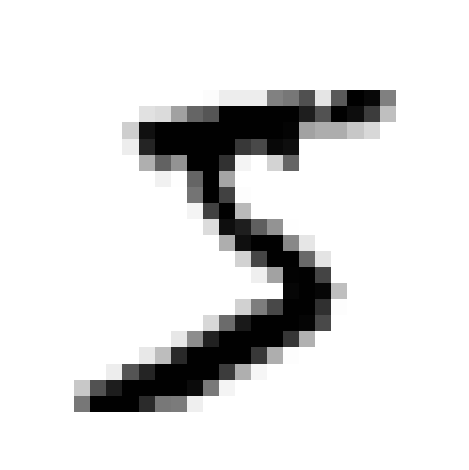

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

ROOT_DIR = "."
CHAPTER_ID = "cp_3"
IMAGES_PATH = os.path.join(ROOT_DIR, "images", CHAPTER_ID)

if not os.path.isdir(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
save_fig("some_digit_plot")
print("画像のラベルは:",y[0]) #label

In [8]:
#数値変換
y = y.astype(np.uint8)

### データの分割
データ取り込んだ時にすでにシャッフルされているため略

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
#画像の描画関数(補助)
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")


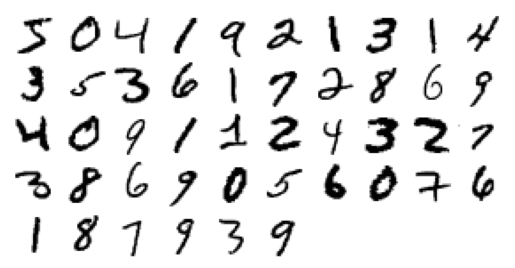

In [11]:
#画像の描画関数2, 画像複数表示
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    #print("padded_instances:", padded_instances)
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)

    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plot_digits(X[:46])

## 2分類機の構成

まずはsklearnのSGDClassifierによる分類機の作成をする

label=5 or elseの分類とする

```python
from sklearn.linear_model import SGDClassifier
#loss:hinge(SVM) or log(logistic), penalty:l2 or l1 or elastcnet
#tol=~~は許容誤差の指定。これを下回るとmax_iterに関わらず停止(過学習防止)
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, random_state=42)
```

- [SGDClassifier公式ドキュメント](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.SGDClassifier.html)

In [12]:
#モデル構築、予測値、k-fold cross validation
#これが一番簡単なながれ
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

print(sgd_clf.predict(X[:10]))

from sklearn.model_selection import cross_val_score
cross_val_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

cross_val_score.mean()

[ True False False False False False False False False False]


0.9570333333333334

つぎに交差検証を細かく管理するために自分で作成し、交差検証を行う

まだ未理解！！

In [13]:
"""from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import clone

skfolds = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
print(y_train_5)
for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    X_test_fold = X_train[test_idx]
    y_test_fold = y_train_5[test_idx]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))"""

'from sklearn.model_selection import StratifiedGroupKFold\nfrom sklearn.base import clone\n\nskfolds = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)\nprint(y_train_5)\nfor train_idx, test_idx in skfolds.split(X_train, y_train_5):\n    clone_clf = clone(sgd_clf)\n    X_train_folds = X_train[train_idx]\n    y_train_folds = y_train_5[train_idx]\n    X_test_fold = X_train[test_idx]\n    y_test_fold = y_train_5[test_idx]\n    \n    clone_clf.fit(X_train_folds, y_train_folds)\n    y_pred = clone_clf.predict(X_test_fold)\n    n_correct = sum(y_pred == y_test_fold)\n    print(n_correct / len(y_pred))'

SGDClassifierによる分類器をいくつかハイパパラメータを指定して訓練、検証してみる

In [14]:
"""from sklearn.metrics import accuracy_score

params = {
    'model_1': {'loss': 'hinge'},
    "model_2": {"loss": "hinge", "penalty": "l1"},
    'model_3': {'loss': 'log', 'penalty': 'l1'}
}

acc = []

#**paramで展開されて便利!!!
for model_name, param in params.items():
    print(f"--- {model_name} ---")
    clf = SGDClassifier(**param, max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    #正解率
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    acc.append(accuracy)"""


'from sklearn.metrics import accuracy_score\n\nparams = {\n    \'model_1\': {\'loss\': \'hinge\'},\n    "model_2": {"loss": "hinge", "penalty": "l1"},\n    \'model_3\': {\'loss\': \'log\', \'penalty\': \'l1\'}\n}\n\nacc = []\n\n#**paramで展開されて便利!!!\nfor model_name, param in params.items():\n    print(f"--- {model_name} ---")\n    clf = SGDClassifier(**param, max_iter=1000, random_state=42)\n    clf.fit(X_train, y_train)\n    y_pred = clf.predict(X_test)\n    #正解率\n    accuracy = accuracy_score(y_test, y_pred)\n    print(f"Accuracy: {accuracy}")\n    acc.append(accuracy)'

上の実行結果<-１時間近くかかる
```python
--- model_1 ---
Accuracy: 0.874
--- model_2 ---
Accuracy: 0.8762
--- model_3 ---
Accuracy: 0.8757
```

In [15]:
"""#描画
print(acc)
import japanize_matplotlib
plt.figure(figsize=(5,5))
plt.bar(params.keys(), acc, width=0.2)
plt.title("モデルごとのaccuracy")
plt.xlabel(f"Model")
plt.ylabel("Accuracy")
plt.show()

data_to_save = {
    "model": SGDClassifier,
    "params": params,
    "accuracy": acc
}

#保存
file_name = "3models_binary_curassifier"
file_path = os.path.join(".","models_pickle",file_name)

with open(file_path, "wb") as f:
    pickle.dump(data_to_save, f)

with open(file_path, "rb") as f:
    loaded_data = pickle.load(f)
    
loaded_data
#loaded_model = loaded_data["model"]
#loaded_params = loaded_data["params"]
#こんな感じで取り出す
"""


'#描画\nprint(acc)\nimport japanize_matplotlib\nplt.figure(figsize=(5,5))\nplt.bar(params.keys(), acc, width=0.2)\nplt.title("モデルごとのaccuracy")\nplt.xlabel(f"Model")\nplt.ylabel("Accuracy")\nplt.show()\n\ndata_to_save = {\n    "model": SGDClassifier,\n    "params": params,\n    "accuracy": acc\n}\n\n#保存\nfile_name = "3models_binary_curassifier"\nfile_path = os.path.join(".","models_pickle",file_name)\n\nwith open(file_path, "wb") as f:\n    pickle.dump(data_to_save, f)\n\nwith open(file_path, "rb") as f:\n    loaded_data = pickle.load(f)\n    \nloaded_data\n#loaded_model = loaded_data["model"]\n#loaded_params = loaded_data["params"]\n#こんな感じで取り出す\n'

## 分類学習におけると性能評価
<span style="color: red">これがかなり大切</soan>

1. accuracyで判断する危険さ
2. confusion_metricsとprecision,recall,F1値
3. precisionとrecallのトレードオフ
4. ROC曲線
   
    について

### ccuracyで判断する危険さ

まず、画像の表す数値が5であるかの２値分類器に対する交差検証だが、cv=3の時の平均精度は約96%を示している。これはハイパパラメータを動かしても基本的にこれくらいの数字となる。

しかしこれは必ずしもいい分類器とは言えない。

理由としては<span style ="color: yellow">ラベルが5である確率がそもそも9割であり、ランダムにTrue,Falseを予測する分類器でも平均精度9割りを叩き出せる。つまり平均精度を参考にするのはあまりよくない。そこで混同行列によるprecision,recallの必要性が出てくる</span>

### 混同行列による精度検証

*混同行列*:

|  | 予測: Negative | 予測: Positive |
|---|---|---|
| 実際: Negative | TN | FP |
| 実際: Positive | FN | TP | 

混同行列の求め方は以下

```python
from sklearn.metrics import confusion_matrix

confusion_matrix(label, y_train_pred)
```

1. Precision(適合率):正例と予測した中での正解率
    $\frac{TP}{TP+FP}$
    
2. recall(再現率):実際正例の中での正解率
    $\frac{TP}{TP+FN}$
    
3. $F_1$値:precision,recallのavarage

    $F_1 = \frac{2}{\frac{1}{precision}+ \frac{1}{recall}}\\
            = 2\times \frac{precision\times recall}{precision+recall}\\
            =\frac{TP}{TP+\frac{FN+FP}{2}}$


In [16]:
from sklearn.model_selection import cross_val_predict

#いままではcross_val_score()だが、今回はシンプルにラベルの予測値を得る
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_5)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[ True False False ...  True False False]
[[53892   687]
 [ 1891  3530]]


precision,recall,f1の出し方
```Python
from sklearn.metrics import precision_score, recall_score

precision_scores(label, pred)
recall_scores(label, pred)
f1_score(label, pred)
```

In [17]:
#precision and recall
from sklearn.metrics import precision_score, recall_score

#これでも求められるし、混同行列から計算もできる
precision_score(y_train_5, y_train_pred)
precision_scores = cm[1,1]/ (cm[1,1]+cm[0,1])
print(precision_scores)

0.8370879772350012


In [18]:
re = recall_score(y_train_5, y_train_pred)
recall_scores = cm[1,1]/(cm[1,0]+cm[1,1])
print(recall_scores)

0.6511713705958311


つまりaccuracyは94%だとしても、画像が5であると予測したうち、正解率は84%,画像が５であるものの正解率に関しては65%である。つまり35%分は5であることを見落としている。

以下は$F_1$値である。これは分類器を比較する際の単純な方法として使われる

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

### precision recallのトレードオフ

SDGClassifierは決定関数によりスコアを出し、ある閾値よりも高ければ正例、低ければ負例と予測している。つまり、その閾値をあげれば適合率は上がるが再現率は下がり、閾値を挙げれば逆になる。ただし、閾値を挙げるとrecallは下がる一方だが、precisionは一時的に下がるときもある(閾値を挙げたことによる取りこぼしのため)

またsklearnは閾値を直接設定はできないが、決定スコアにはアクセスできるため、閾値を変えたprecision,recallは計算することができる

In [20]:
y_scores_one = sgd_clf.decision_function([X[0]])
print(f"one_score:{y_scores_one}")

threshold = [-10000,0,100,8000,15000]
for th in threshold:
    y_scores = sgd_clf.decision_function(X_train)
    y_pred_threshold = (y_scores > [th]*len(y_scores))
    print()
    print(f"threshold:{th}")
    print(precision_score(y_train_5, y_pred_threshold))
    print(recall_score(y_train_5,y_pred_threshold))
    print(f1_score(y_pred_threshold, y_train_5))

one_score:[2164.22030239]

threshold:-10000
0.10572644043208061
0.9948349013097214
0.19113946482367536

threshold:0
0.6805026118876183
0.8891348459693783
0.7709532949456174

threshold:100
0.6953045500799535
0.882309536985796
0.7777235772357723

threshold:8000
0.9872340425531915
0.1283895960154953
0.22722820763956905

threshold:15000
0.9333333333333333
0.002582549345139273
0.0051508462104488595


閾値を動かしたときのprecision,recallの値(PR曲線)をグラフに可視化してみる

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

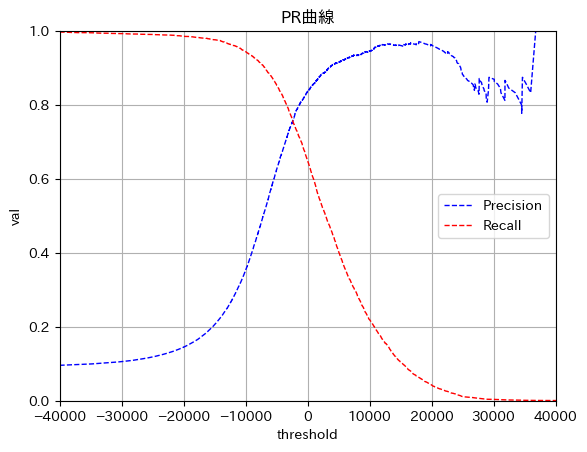

In [22]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision",linewidth=1)
plt.plot(thresholds, recalls[:-1], "r--", label="Recall", linewidth=1)
plt.title("PR曲線")
plt.xlabel("threshold")
plt.ylabel("val")
plt.grid(True)
plt.axis([-40000,40000,0,1])
plt.legend(loc="center right")

上記のグラフからトレードオフの関係が見て取れる。閾値の設定だが、閾値を挙げていくとprecisionが一時的に下がるため、precisionが下がる直前(threshold=24000)あたりが適している(場合による。8000位の時もある)

precision,recallの値をもとに閾値の調整を行う->argmax()利用
```python
recall_90_precision = recalls[np.argmax(precisions>=0.9)]
threshold_90_precision = thresholds[np.argmax(precisions>=90)]
```

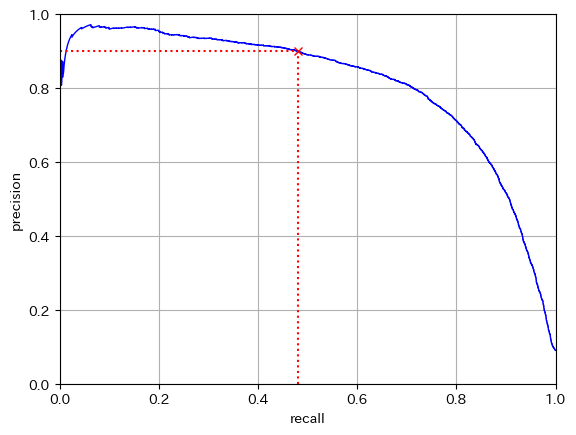

In [45]:
#precision vs recall
plt.plot(recalls, precisions, "b-", linewidth=1)
plt.xlabel("recall")
plt.ylabel("precision")
plt.axis([0,1,0,1])
plt.grid(True)

#precision=90%を閾値としたいときはargmax()でそのthresholdもとめる
recall_90_precision = recalls[np.argmax(precisions>=0.9)]
threshold_90_precision = thresholds[np.argmax(precisions>=90)]

plt.plot([recall_90_precision,recall_90_precision], [0,0.9], "r:")
plt.plot([0,recall_90_precision],[0.9,0.9],"r:")
plt.plot([recall_90_precision], [0.9],"rx")


### ROC曲線
ROC(Reciever Operating Characteristic):偽陽性率に対する真陽性率(再現率)のプロットしたものROCについても真陽性率が上がれば、偽陽性率が上がるため、トレードオフの関係にある

優れた分類器は左上に沿って線が広がる。つまり、ROC曲線下の面積が大きければより良い分類器となる。

->AUC(Area Under Curve):曲線下面積のこと
コードは以下

```python
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(label, pred)
plt.plot(fpr, tpr)

roc_auc_score(label, pred)
```



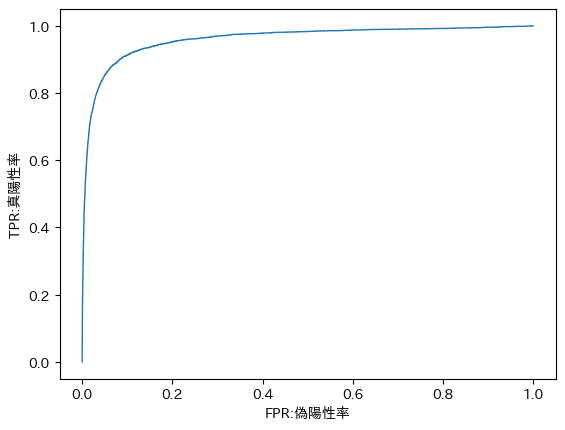


0.9604938554008616


In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr ,thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth=1, label="ROC Curve")
plt.xlabel("FPR:偽陽性率")
plt.ylabel("TPR:真陽性率")
plt.show()
print()
auc = roc_auc_score(y_train_5, y_scores)
print(auc)

<span style="color:yellow">目安として、陽性クラスが珍しいor偽陰性より偽陽性に関心があるときにPR曲線を使い、そのほかでROC曲線を使う!!!</span>

最後にSGDClassifierに加えてRandomForestClassifierモデルに対して混同行列、PR曲線、ROC曲線の比較を行う

In [25]:
#label:y_train_5
sgd_threshods = thresholds
sgd_precision = precisions
sgd_recall = recalls
sgd_fpr, sgd_tpr = fpr, tpr
sgd_auc = auc

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,cv=3,
                                    method="predict_proba")
print(y_probas_forest)
y_scores_forest = y_probas_forest[:,1]
forest_precisions, forest_recalls, forest_thresholds = precision_recall_curve(y_train_5, y_scores_forest)
forest_fpr, forest_tpr, dorest_thresholds = roc_curve(y_train_5, y_scores_forest)


[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 ...
 [0.02 0.98]
 [0.92 0.08]
 [0.94 0.06]]


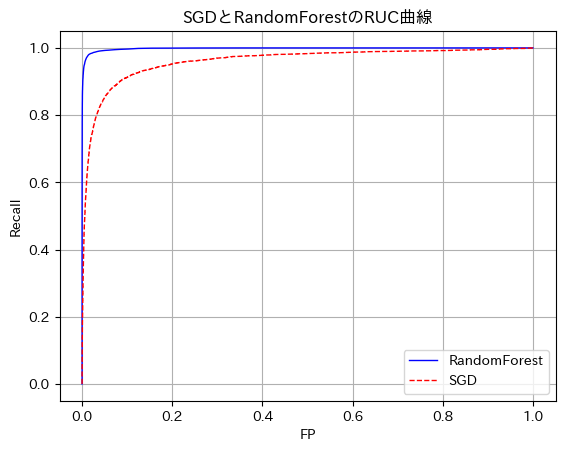

SGD's AUC: 0.9604938554008616
Random Forest's AUC: 0.9983436731328145


In [26]:
plt.plot(forest_fpr, forest_tpr, "b-",linewidth=1, label="RandomForest")
plt.plot(sgd_fpr, sgd_tpr, "r--",linewidth=1, label="SGD")
plt.title("SGDとRandomForestのRUC曲線")
plt.xlabel("FP")
plt.ylabel("Recall")
plt.grid(True)
plt.legend(loc="best")
plt.show()

forest_auc = roc_auc_score(y_train_5, y_scores_forest)
print(f"SGD's AUC: {sgd_auc}")
print(f"Random Forest's AUC: {forest_auc}")

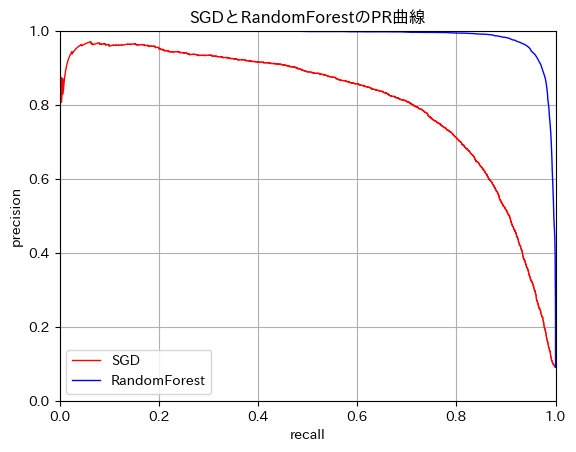

In [27]:
plt.plot(sgd_recall, sgd_precision, "r-", linewidth=1, label="SGD")
plt.plot(forest_recalls, forest_precisions, "b-",linewidth=1, label="RandomForest")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("SGDとRandomForestのPR曲線")
plt.axis([0,1,0,1])
plt.legend(loc="best")
plt.grid(True)

## 多クラス分類

1. 他クラス分類器の性質と作成
2. 誤判別に対する分析
3. マルチベクトルに対する分類
4. ノイズを除去する分類器の作成

### 他クラス分類器の性質と作成
他クラス分類を直接実装できるもの(ランダムフォレスト分類器や単純ベイズ分類器)と、２クラス分類しか実装できないもの(ロジスティック回帰分類器やSVM分類器)がある。２クラス分類しかできない場合には分類器をクラス数Nに対して$\frac{N(N-1)}{2}$個用意し、スコアを計算することで多項クラス分類器を作成する。

また、分類器は0 or 0以外を判別するのか、0 or 1を分類するのかで分類器の種類が変わってくる。OVA(One versus All)法とOVO(One versus One)法と呼ばれる

実行時間がネックにならない限り、基本的にはOVA(OVRest)法が好まれる。


In [28]:
#SVCにおけるOVO
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)# gamma="auto"はカーネル関数の係数を自動決定
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

some_digit_score = svm_clf.decision_function([some_digit])
display(some_digit_score,  np.argmax(some_digit_score), svm_clf.classes_)

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

5

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

<span style= "color: red">分類器は訓練時にclasss_属性に値の順序ターゲットとクラスのリストを管理する。今回は0~9の数値がpreictの配列idxに一致しているが、本来は調整が必要</span>

上記のSVCはOVOを行っている。明示的にOVAやOVOを行いたいときはOneVsClassifierかOneRestClassifierを使うことでできる(以下のコード)。

In [29]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SVC(gamma="auto",random_state=42))
ovo_clf.fit(X_train[:1000], y_train[:1000])
ovo_clf.predict([some_digit])


array([5], dtype=uint8)

In [30]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto",random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [31]:
display(ovo_clf.decision_function([some_digit]),
ovr_clf.decision_function([some_digit]))

display(ovo_clf.decision_function([X[10]]),
ovr_clf.decision_function([X[10]]))

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

array([[-0.9990256 , -0.99963766, -0.99949709, -0.99902667, -0.99986906,
         0.10132159, -0.99976287, -0.99933311, -0.99943631, -0.99924045]])

array([[ 2.81585438,  7.09167958,  3.82972099,  9.2974869 ,  5.8885703 ,
         0.78950589,  1.79862509,  8.10392157, -0.22784964,  4.83753243]])

array([[-1.00000216, -0.99963766, -0.99949709,  0.10253583, -0.99986906,
        -0.99926435, -0.99976287, -0.99933311, -0.99943631, -0.99924045]])

明示的にovo,ovr指定した時のある画像のスコア結果と明示しないときのスコア見るとやはり明示しないときはovrであることがわかる(random_state指定する)訓練データ1000枚など荒いところはあるが、ovoの方がスコアがはっきりしていることがわかる

以下はSGDの他クラス分類である。SGDは他クラス分類に対応しているためOVO,OVRの指定は必要ない

In [32]:
sgd_clf.fit(X_train[:1000], y_train[:1000])
sgd_clf.decision_function([some_digit])

array([[-6049581.97985829, -6138036.45541781, -3886281.38604605,
         -604692.42366776, -6948311.32017537,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

上記がSGDによる分類スコアである。SVC()よりもはっきりと分類できている

In [33]:
"""#モデル評価
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")"""

'#モデル評価\ncross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")'

スケーリングすることによる値の変化

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train.astype(np.float64))
#clf_scaled_score = cross_val_score(sgd_clf, X_trained_scaled, y_train, cv=3,scoring="accuracy")

なぜか上二つのセルのk-fold cross validation出来ない

### 誤判別に対する分析
予測値に対する混同行列を求めそれを可視化することでどこで誤判別が生まれてるか明らかにする

In [35]:
y_train_pred = sgd_clf.predict(X_trained_scaled)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5786,    4,   23,   13,    7,    4,   58,    4,   24,    0],
       [   6, 6640,   25,   13,    7,    1,   14,   10,   23,    3],
       [ 237,  379, 4628,   71,   56,   10,  384,   80,   90,   23],
       [ 184,  462,  380, 4066,   40,  375,   95,  318,  186,   25],
       [  65,  231,   81,   49, 4965,   74,  171,   80,   59,   67],
       [ 362,  281,   57,  266,  192, 3563,  252,  136,  265,   47],
       [ 121,  149,   80,    0,   17,   56, 5475,    7,   13,    0],
       [  95,  153,   92,  135,   50,    9,   19, 5633,   47,   32],
       [ 455,  834,  120,  118,  129,  483,  165,  196, 3298,   53],
       [ 264,  276,   68,  172,  606,  232,   29, 1836,  141, 2325]],
      dtype=int64)

混同行列は縦が実際のラベル、横が予測ラベルとなる

Saving figure confusion_matrix_plot


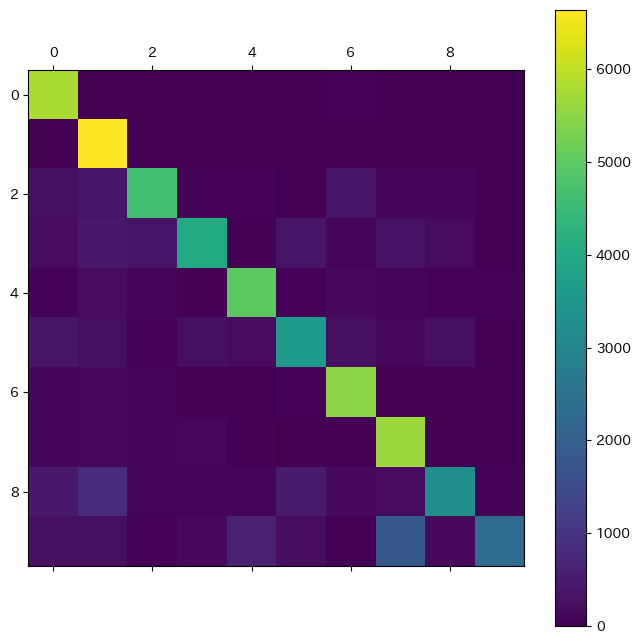

In [36]:
#visualization
def plot_confusion_matrics(matrics):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrics)
    fig.colorbar(cax)
    
plot_confusion_matrics(conf_mx)
#plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Saving figure confusion_matrix_errors_plot


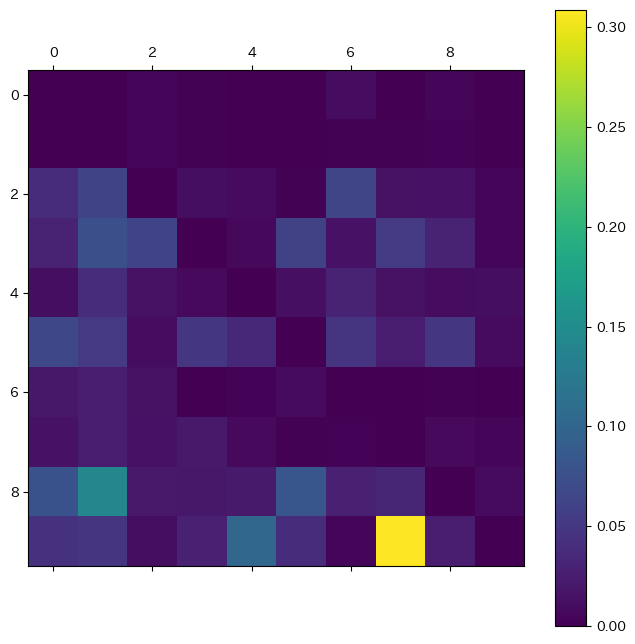

In [37]:
#母数を反映して割合で判定する
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrics(norm_conf_mx)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
#display(norm_conf_mx)
plt.show()

教材で行っているsgd_clfのcv=3のクロスバリデーションモデルでは列8,9が比較的明るく(実際の８は正しく分類されているが、他の文字が８と間違われている)、3と5は双方向に明るくなっている。しかしこのモデルだと9が7に誤判別されている割合がかなり多いことがわかる。(画像からもあまりいい判別器とはいえなそう)

では7,9に対して具体的な画像取り出してみる

Saving figure error_analysis_digits_plot


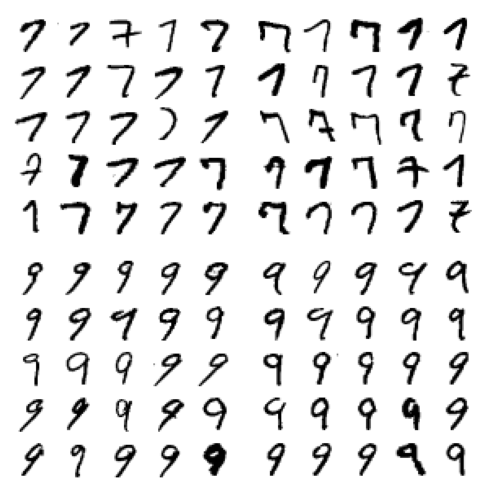

In [38]:
X_77 = X_train[(y_train==7) & (y_train_pred==7)]
X_79 = X_train[(y_train==7) & (y_train_pred==9)]
X_97 = X_train[(y_train==9) & (y_train_pred==7)]
X_99 = X_train[(y_train==9) & (y_train_pred==9)]

plt.figure(figsize=(5,5))
plt.subplot(221); plot_digits(X_77[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_79[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_97[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_99[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

### 他ラベル分類

今回のラベルは1値であるが、物体検地などでは男性、Aさん、怒っているなどラベルが存在することがある。このようなときのアプローチ

今回は0~9のラベルに加えて、正解ラベルに手で偶奇、５以上であるかのラベルは加えて判別を行う

In [39]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=5)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd] #c_は列方向に結合
display(y_multilabel[:5])

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

array([[ True,  True],
       [False, False],
       [False, False],
       [False,  True],
       [ True,  True]])

KNeighborsClassifier()

In [40]:
knn_clf.predict([some_digit])

y_train_knn_pred = cross_val_predict(knn_clf, X_train[:1000], y_multilabel[:1000], cv=3)
f1_score(y_multilabel[:1000], y_train_knn_pred[:1000], average="macro")

0.9063762655555452

### ノイズ除去する分類器の作成

In [41]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test+noise
y_train_mod = X_train
y_test_mod = X_test


Saving figure noisy_digit_example_plot


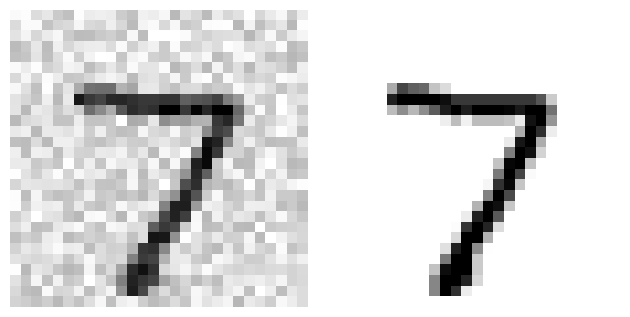

In [42]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


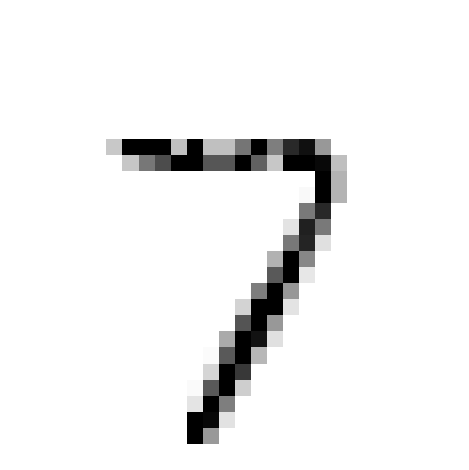

In [43]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")